In [1]:
import os
os.listdir(r'/kaggle/input/nudtsirst')

['nudtsirst',
 'annotation_train.csv',
 'annotation_test.csv',
 'annotation.csv',
 'mask']

In [2]:
! pip install torchsummary

In [3]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
test_annotation = pd.read_csv('/kaggle/input/nudtsirst/annotation_test.csv')
test_annotation = test_annotation['no'].tolist()
test_annotation = [dir.replace('\\','/') for dir in test_annotation]

train_annotation = pd.read_csv('/kaggle/input/nudtsirst/annotation_train.csv')
train_annotation = train_annotation['no'].tolist()
train_annotation = [dir.replace('\\','/') for dir in train_annotation]

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2

from torchsummary import summary

In [6]:
class IRSTDataLoader(torch.utils.data.Dataset):
    def __init__(self, annotation, 
                 input_path = '/kaggle/input/nudtsirst/nudtsirst/',
                 mask_path  = '/kaggle/input/nudtsirst/mask/',
                 data_transform = transforms.ToTensor()):
        super(IRSTDataLoader, self).__init__()
        self.annotation = annotation
        self.image_input = [input_path+img_path for img_path in annotation] #img_list
        
        self.mask_input = [mask_path+img_path for img_path in annotation]
        
        self.data_transform = data_transform
        
    def __getitem__(self, index):
        img_input = self.image_input[index]
        mask_input = self.mask_input[index]
        
        img = self.data_transform(Image.open(img_input))
        
        mask = self.data_transform(Image.open(mask_input))[0]
        
        tag = img_input
        
        return img, mask, tag
    
    def __len__(self):
        return len(self.annotation)
        

In [7]:
batch_size = 4

In [8]:
train_dl = IRSTDataLoader(train_annotation)
test_dl  = IRSTDataLoader(test_annotation)

valid_sz = 200
train_dl, valid_dl = random_split(train_dl,[len(train_dl)-valid_sz,valid_sz])
train_dataloader = DataLoader(train_dl, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dl, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dl,  batch_size=batch_size, shuffle=True)

In [9]:
len(train_dataloader), len(valid_dataloader)

(9415, 50)

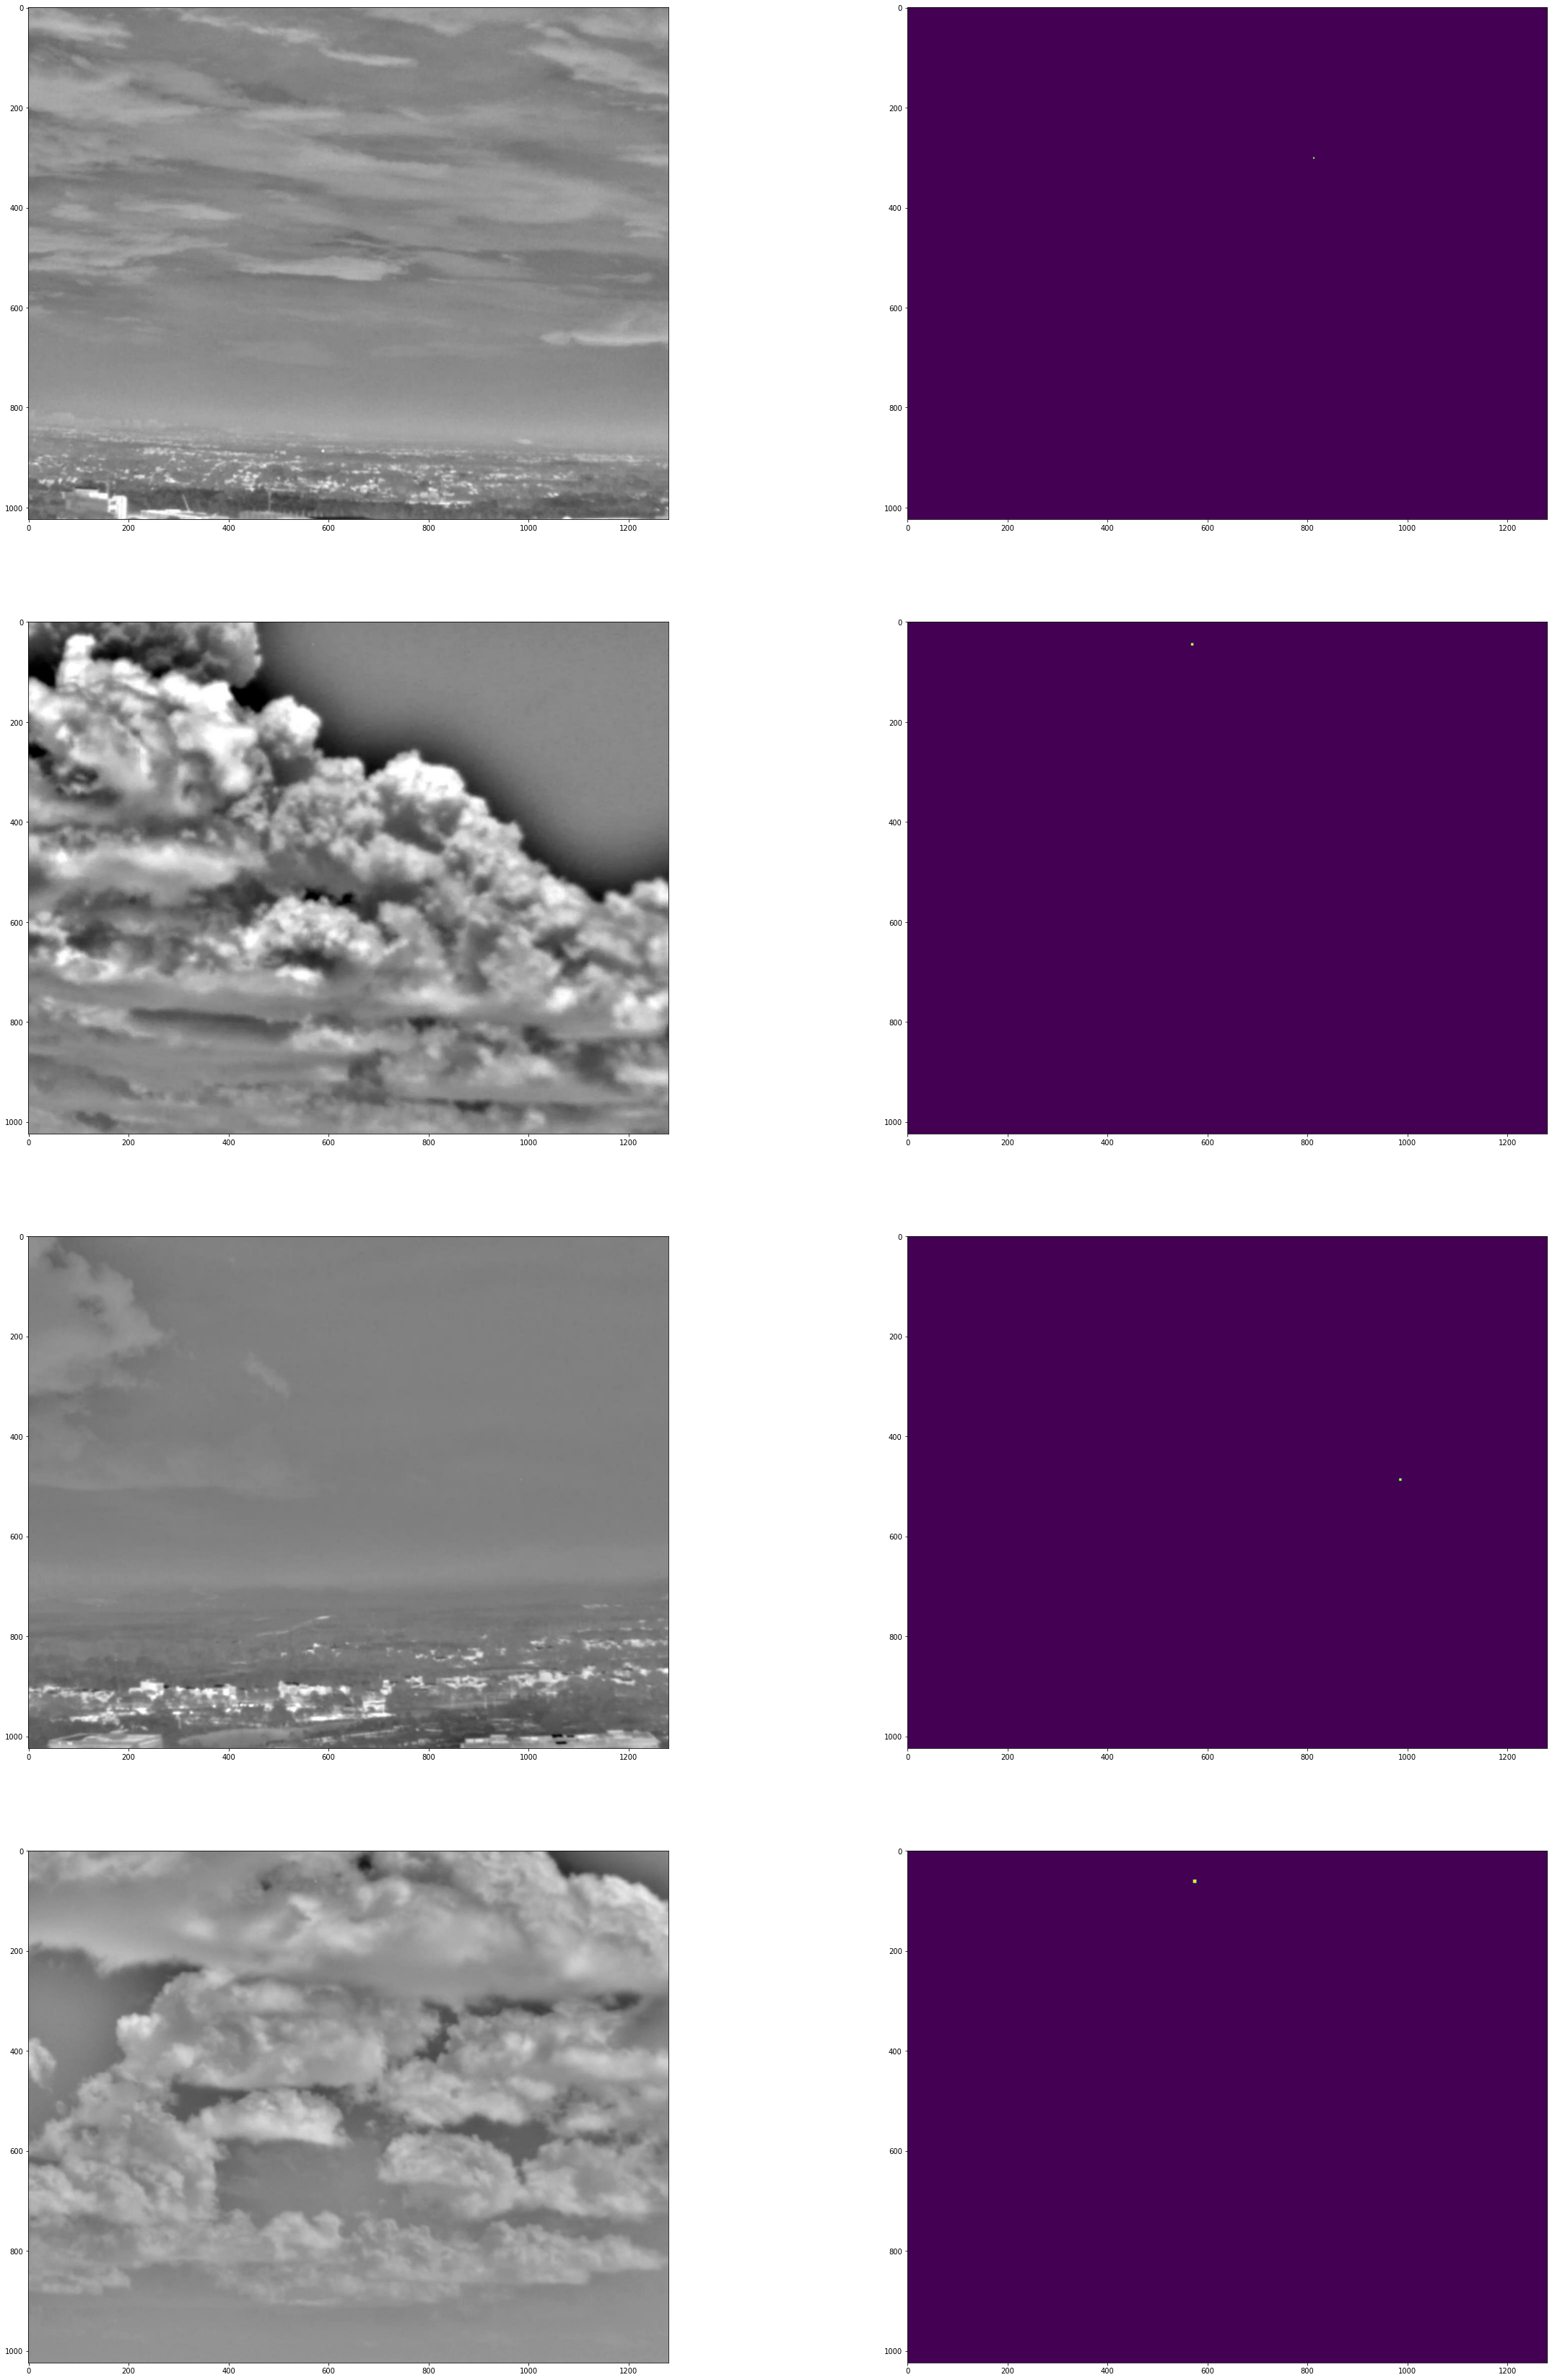

In [10]:
fig, ax = plt.subplots(4,2,figsize = (40,60))
for i, (data,targets,tag) in enumerate(test_dataloader):
    #data, targets = data.to(device), targets.to(device)
    d1 = data
    t1 = targets
    break
for i in range(4):
    ax[i][0].imshow(d1[i].permute(1,2,0))
    ax[i][1].imshow(t1[i])

In [11]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7e7184da5f1243ad99dda1f5c6872387820b3c64f06683b0b4e57dd2da4ab391
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1df9d8488045b2128efeaba571a1547066217bd5054c4bdcd97d59a771f9e52b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
import segmentation_models_pytorch as smp
from torchsummary import summary

In [14]:
pretrained_model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100",        
    encoder_weights="imagenet",     
    classes=1,
    encoder_depth = 3,
    decoder_channels=[64, 32, 16]
)
summary(pretrained_model.to(device), (3, 1024, 1280))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 16, 512, 640]             432
       BatchNorm2d-2         [-1, 16, 512, 640]              32
         Hardswish-3         [-1, 16, 512, 640]               0
            Conv2d-4         [-1, 16, 512, 640]             144
       BatchNorm2d-5         [-1, 16, 512, 640]              32
              ReLU-6         [-1, 16, 512, 640]               0
          Identity-7         [-1, 16, 512, 640]               0
            Conv2d-8         [-1, 16, 512, 640]             256
       BatchNorm2d-9         [-1, 16, 512, 640]              32
         Identity-10         [-1, 16, 512, 640]               0
DepthwiseSeparableConv-11         [-1, 16, 512, 640]               0
           Conv2d-12         [-1, 64, 512, 640]           1,024
      BatchNorm2d-13         [-1, 64, 512, 640]             128
             ReLU-14         [-1, 

In [15]:
pretrained_model = nn.DataParallel(pretrained_model)
model = pretrained_model.to(device)

In [16]:
learning_rate = 0.0001
loss_function = smp.losses.DiceLoss(mode = 'binary')

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# Model path
checkpoint = 'model.pth'


epoch_train_loss_array = []
epoch_valid_loss_array = []
train_loss_array = []
valid_loss_array = []

In [17]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/IRST_Unet_1')

In [18]:
import time

checkpoint = 'model.pth'
max_val_loss = 1

def train(train_dataloader, valid_dataloader, epoch, small_step = 250, display_step = 1250):
    print(f"Start epoch #{epoch+1}")
    start_time = time.time()
    step_loss = 0
    train_loss_epoch = 0
    val_loss_epoch   = 0
    global max_val_loss
    model.train()
    for i, (data,targets,tag) in enumerate(train_dataloader):
        
        # Load data to GPU
        data, targets = data.to(device), targets.to(device)

        # Clear gradient
        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        step_loss += loss.item()
        if (i+1) % display_step == 0:
            val_loss = 0
            for _, (val_data,val_targets,val_tag) in enumerate(valid_dataloader):
                val_data, val_targets = val_data.to(device), val_targets.to(device)
                val_output = model(val_data)
                val_loss_batch   = loss_function(val_output, val_targets.long()).item()
                val_loss += val_loss_batch
            print('Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.4f}\tVal loss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                step_loss/small_step, val_loss/len(valid_dataloader)))
            
            writer.add_scalar('Loss/train', step_loss/small_step, (epoch+1)*(i+1))
            writer.add_scalar('Loss/valid', val_loss/len(valid_dataloader), (epoch+1)*(i+1))
            train_loss_array.append(step_loss/small_step)
            valid_loss_array.append(val_loss/len(valid_dataloader))
            
            step_loss = 0
            torch.save(model,checkpoint)
            
            if val_loss/len(valid_dataloader)<max_val_loss:
                max_val_loss = val_loss/len(valid_dataloader)
                torch.save(model,'best.pth')
            
        elif (i+1) % small_step == 0:
            print('Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                step_loss/small_step))
            
            writer.add_scalar('Loss/train', step_loss/small_step, (epoch+1)*(i+1))
            train_loss_array.append(step_loss/small_step)
            
            step_loss = 0
            torch.save(model,checkpoint)
            
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
     
    for _, (val_data,val_targets,val_tag) in enumerate(valid_dataloader):
        val_data, val_targets = val_data.to(device), val_targets.to(device)
        val_output = model(val_data)
        val_loss_batch = loss_function(val_output, val_targets.long()).item()
        val_loss_epoch += val_loss_batch
    
    writer.add_scalar('EpochLoss/train', train_loss_epoch/len(train_dataloader), (epoch+1))
    writer.add_scalar('EpochLoss/valid', val_loss_epoch/len(valid_dataloader), (epoch+1))
    epoch_train_loss_array.append(train_loss_epoch/len(train_dataloader))
    epoch_valid_loss_array.append(val_loss_epoch/len(valid_dataloader))
    
    print(f'Train loss for this epoch: {train_loss_epoch/len(train_dataloader)}')
    print(f'Valid loss for this epoch: {val_loss_epoch/len(valid_dataloader)}')
    
    if val_loss_epoch/len(valid_dataloader)<max_val_loss:
        max_val_loss = val_loss_epoch/len(valid_dataloader)
        torch.save(model,'best.pth')
    
    print('-'*20)
    

    return train_loss_epoch/len(train_dataloader)

In [19]:
checkpoint = 'model.pth'
for epoch in range(4):
    train_loss_epoch = train(train_dataloader, valid_dataloader, epoch)
    torch.save(model,checkpoint)

Start epoch #1
Train Epoch: 1 [1000/37657 (2.656%)]	Loss: 0.9999
Train Epoch: 1 [2000/37657 (5.311%)]	Loss: 0.9868
Train Epoch: 1 [3000/37657 (7.967%)]	Loss: 0.4659
Train Epoch: 1 [4000/37657 (10.622%)]	Loss: 0.1611
Train Epoch: 1 [5000/37657 (13.278%)]	Loss: 0.1178	Val loss: 0.1199
Train Epoch: 1 [6000/37657 (15.933%)]	Loss: 0.1014
Train Epoch: 1 [7000/37657 (18.589%)]	Loss: 0.0949
Train Epoch: 1 [8000/37657 (21.244%)]	Loss: 0.0790
Train Epoch: 1 [9000/37657 (23.900%)]	Loss: 0.0757
Train Epoch: 1 [10000/37657 (26.555%)]	Loss: 0.0691	Val loss: 0.0835
Train Epoch: 1 [11000/37657 (29.211%)]	Loss: 0.0660
Train Epoch: 1 [12000/37657 (31.867%)]	Loss: 0.0642
Train Epoch: 1 [13000/37657 (34.522%)]	Loss: 0.0706
Train Epoch: 1 [14000/37657 (37.178%)]	Loss: 0.0537
Train Epoch: 1 [15000/37657 (39.833%)]	Loss: 0.0472	Val loss: 0.0463
Train Epoch: 1 [16000/37657 (42.489%)]	Loss: 0.0521
Train Epoch: 1 [17000/37657 (45.144%)]	Loss: 0.0494
Train Epoch: 1 [18000/37657 (47.800%)]	Loss: 0.0545
Train Epoc

In [20]:
# Thanks to Nguyen Tong Minh for this code piece
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ./ngrok-stable-linux-amd64.zip
!./ngrok authtoken 2JN81vOctEUZf7La43otOE6t2NQ_3hGeAof4T4KsEG6C8mWiX 
# this token should be kept in Kaggle's Secrets, but okay
import os
import multiprocessing
 
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None)
                        for cmd in [
                        f"tensorboard --logdir ./runs/ --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]
import time
time.sleep(10) # wait for tensorboard host
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-12-30 13:09:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  41.7MB/s    in 0.3s    

2022-12-30 13:09:50 (41.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ./ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
https://687e-34-123-22-39.ngrok.io


2022-12-30 13:10:05.564228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 13:10:05.567132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 13:10:05.964195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 13:10:05.965470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 13:10:05.966392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

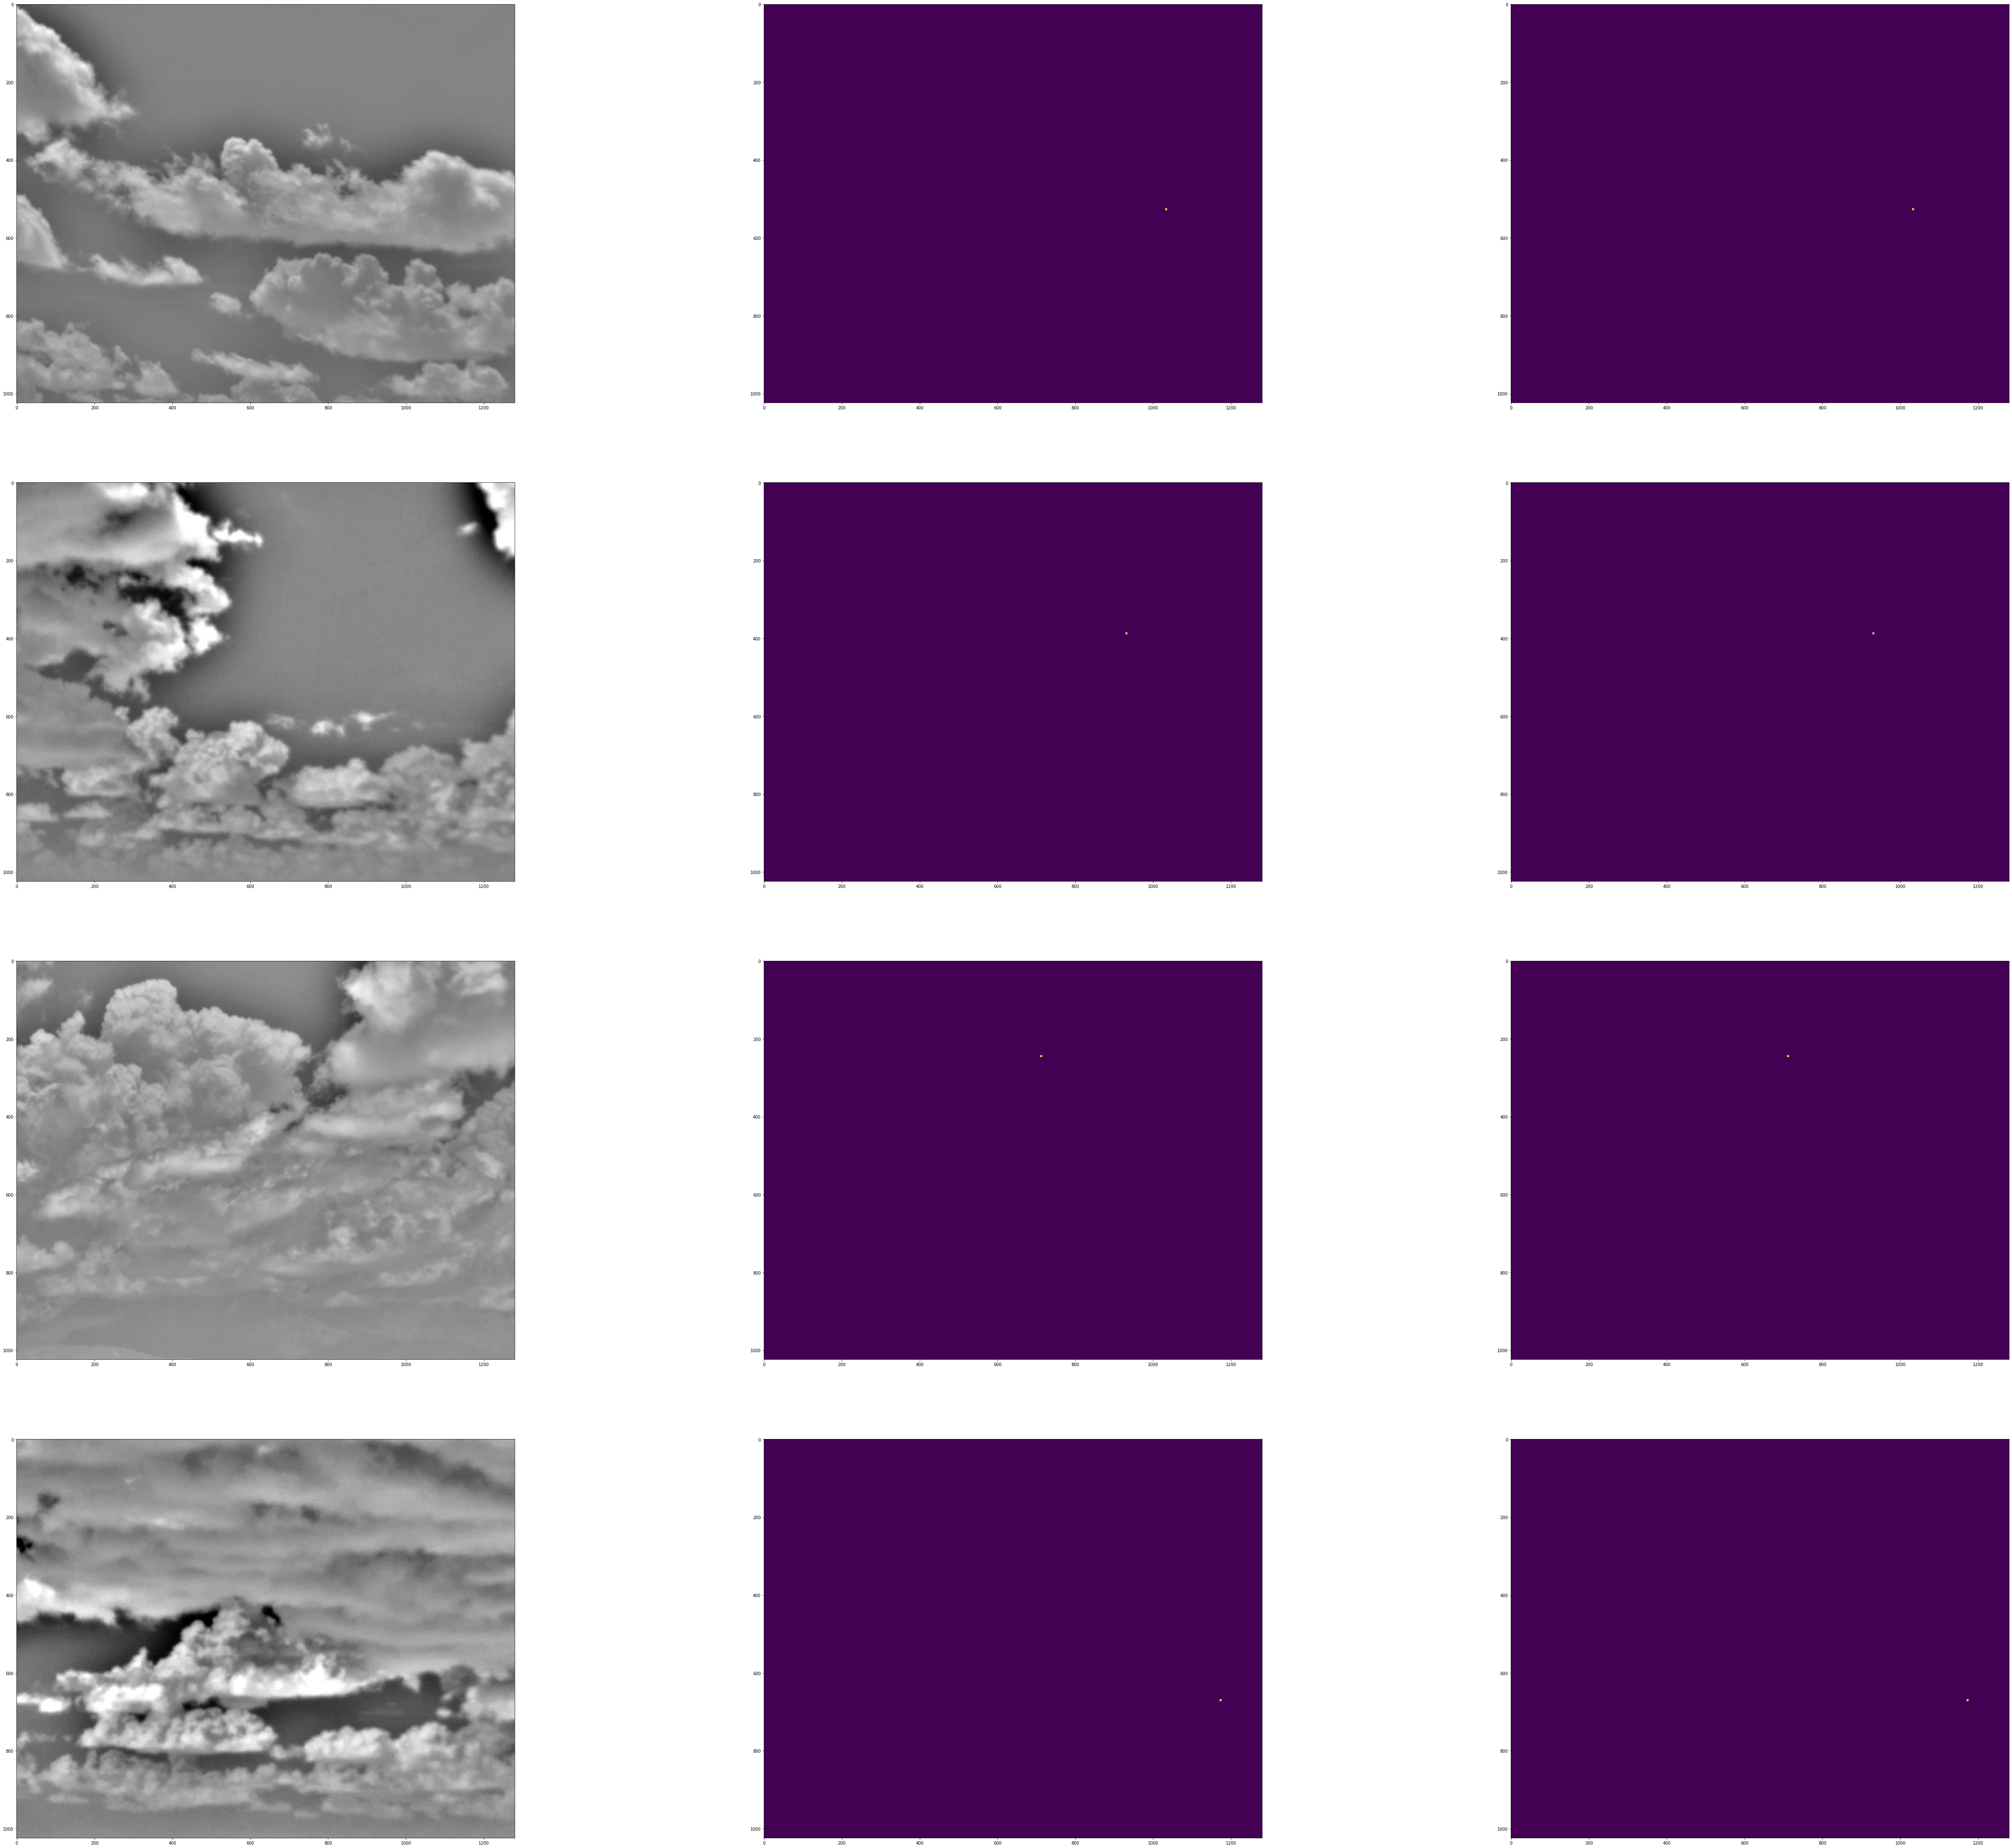

In [21]:
fig, ax = plt.subplots(4,3,figsize = (90,80))
for i, (data,targets,tag) in enumerate(test_dataloader):
    #data, targets = data.to(device), targets.to(device)
    d1 = data
    t1 = targets
    break
for i in range(4):
    ax[i][0].imshow(d1[i].permute(1,2,0))
    ax[i][1].imshow(t1[i])
    res = (model(d1)[i]).cpu().detach().numpy()[0]
    masked_res = np.where(res>0.2*np.max(res),255,0)
    ax[i][2].imshow(masked_res)
    
plt.savefig('test.png')

In [1]:
import cv2
import pandas as pd

to_df = {'Sample':[], 'x':[], 'y':[], 'w':[], 'h':[]}

for _, (test_img, test_mask, test_tag) in enumerate(test_dataloader):
    for i in range(test_img.shape[0]):
        res = (model(test_img)[i]).cpu().detach().numpy()[0]
        masked_res = np.uint8(np.where(res>0.2*np.max(res),255,0))
        contours = \
            cv2.findContours(masked_res,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
        for coor in contours:
            to_df['Sample'].append(test_tag[i])
            bdr = cv2.boundingRect(coor)
            to_df['x'].append(bdr[0]+1)
            to_df['y'].append(bdr[1]+1)
            to_df['w'].append(bdr[2])
            to_df['h'].append(bdr[3])
    if (_+1)%100 == 0:
        print((_+1),'/',len(test_dataloader), ' done')
df = pd.DataFrame(to_df)
df.to_csv('unet_results.csv')
print('done!')

done!
